In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

# Charger X_full / y_full sauvegardés depuis data_exploration
data_dir = Path("/data/processed")
X_full = joblib.load(data_dir / "X_full.joblib")
y_full = joblib.load(data_dir / "y_full.joblib")

print("Shape X_full:", X_full.shape)
print("Shape y_full:", y_full.shape)
print("Classes :", np.unique(y_full))


Shape X_full: (10299, 561)
Shape y_full: (10299,)
Classes : [1 2 3 4 5 6]


In [2]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_full,
    y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)

# Standardisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train: (8239, 561) X_test: (2060, 561)


In [3]:
search_space = {
    "log_reg": {
        "estimator": LogisticRegression(
            max_iter=1000,
            n_jobs=-1    # multi_class par défaut (pas de warning)
        ),
        "param_grid": {
            "C": [0.1, 1.0, 10.0],
            "penalty": ["l2"],
            "solver": ["lbfgs"],   # on enlève 'saga' pour aller plus vite
        },
    },
    "random_forest": {
        "estimator": RandomForestClassifier(
            random_state=42,
            n_jobs=-1
        ),
        "param_grid": {
            "n_estimators": [150, 300],
            "max_depth": [None, 25],
            "min_samples_split": [2, 5],
        },
    },
    "svm_rbf": {
        "estimator": SVC(
            kernel="rbf",
            probability=True,
            random_state=42
        ),
        "param_grid": {
            "C": [1.0, 10.0],
            "gamma": ["scale", 0.01],
        },
    },

}

In [5]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_results = {}

for name, cfg in search_space.items():
    print("\n=======================")
    print(f"GridSearch for: {name}")
    print("=======================")

    estimator = cfg["estimator"]
    param_grid = cfg["param_grid"]

    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring="accuracy",
        n_jobs=-1,
        cv=cv,
        verbose=1
    )

    # IMPORTANT : on utilise X_train_scaled / y_train
    grid.fit(X_train_scaled, y_train)

    print("Best params:", grid.best_params_)
    print("Best CV accuracy:", grid.best_score_)

    # Évaluation sur le test
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    acc_test = accuracy_score(y_test, y_pred)

    print("Test accuracy:", acc_test)

    grid_results[name] = {
        "best_estimator": best_model,
        "best_params": grid.best_params_,
        "cv_score": grid.best_score_,
        "test_accuracy": acc_test,
        "y_pred_test": y_pred,
    }



GridSearch for: log_reg
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV accuracy: 0.9786377564507238
Test accuracy: 0.9849514563106796

GridSearch for: random_forest
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params: {'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 300}
Best CV accuracy: 0.9741471262697755
Test accuracy: 0.9830097087378641

GridSearch for: svm_rbf
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'C': 10.0, 'gamma': 'scale'}
Best CV accuracy: 0.9822787983942932
Test accuracy: 0.987378640776699


In [6]:
grid_summary = pd.DataFrame([
    {
        "model": name,
        "cv_accuracy": res["cv_score"],
        "test_accuracy": res["test_accuracy"],
        "best_params": res["best_params"]
    }
    for name, res in grid_results.items()
]).sort_values("test_accuracy", ascending=False)

grid_summary


,model,cv_accuracy,test_accuracy,best_params
2,svm_rbf,0.982279,0.987379,"{'C': 10.0, 'gamma': 'scale'}"
0,log_reg,0.978638,0.984951,"{'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}"
1,random_forest,0.974147,0.983010,"{'max_depth': 25, 'min_samples_split': 2, 'n_e..."


In [7]:
# On part de grid_summary et grid_results que tu as déjà

best_model_name = grid_summary.iloc[0]["model"]
best = grid_results[best_model_name]

best_model = best["best_estimator"]
y_pred_best = best["y_pred_test"]

print("Best model:", best_model_name)
print("Best params:", best["best_params"])
print("CV accuracy:", best["cv_score"])
print("Test accuracy:", best["test_accuracy"])


Best model: svm_rbf
Best params: {'C': 10.0, 'gamma': 'scale'}
CV accuracy: 0.9822787983942932
Test accuracy: 0.987378640776699


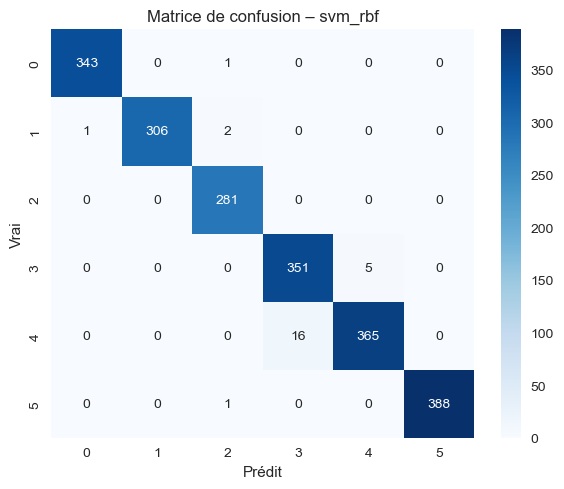

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title(f"Matrice de confusion – {best_model_name}")
plt.tight_layout()
plt.show()


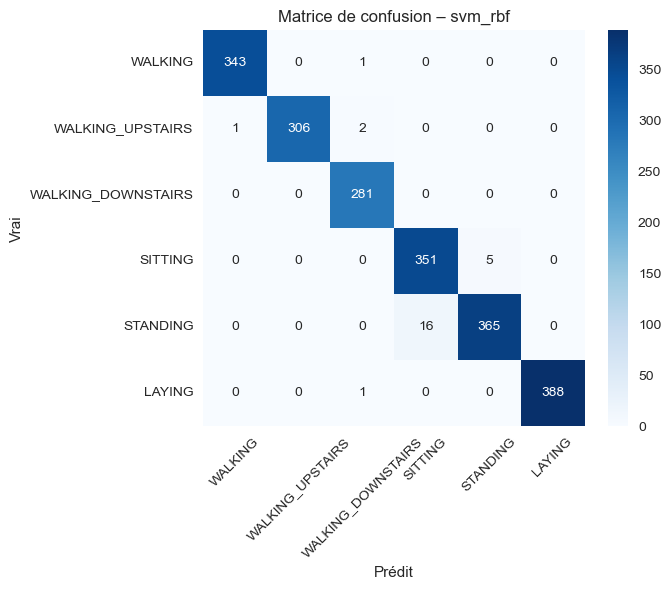

In [12]:
activity_labels_df = pd.read_csv("C:/Users/hp/Downloads/MLFLOW_HumanActivity/data/raw/UCI HAR Dataset/activity_labels.txt", sep=r"\s+", header=None, names=["id", "label"])
activity_labels = dict(zip(activity_labels_df["id"], activity_labels_df["label"]))

activity_labels
labels_sorted = [activity_labels[i] for i in sorted(activity_labels.keys())]

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_sorted,
            yticklabels=labels_sorted)
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title(f"Matrice de confusion – {best_model_name}")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
